# Classifiers Evaluation

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from master_thesis_experiments.main.synth_classification_simulation import SynthClassificationSimulation
from master_thesis_experiments.simulator_toolbox.generator.synth_classification_generator import SynthClassificationGenerator
from master_thesis_experiments.adaptation.density_estimation import MultivariateNormalEstimator
from sklearn.model_selection import train_test_split

### Generating Data

In [26]:
N_FEATURES = 2
N_OUTPUTS = 1
N_CLASSES = 3

simulation = SynthClassificationSimulation(
    name="classifiers_evaluation",
    generator=SynthClassificationGenerator(
        n_features=N_FEATURES, n_outputs=N_OUTPUTS, n_classes=N_CLASSES
    ),
    strategies=[],
    results_dir="",
    n_samples=1,
    estimator_type=MultivariateNormalEstimator
)

In [27]:
simulation.generate_dataset(
    n_concepts=1,
    concept_size=1,
    last_concept_size=400

)

[DEBUG] [master_thesis_experiments.main.synth_classification_simulation] [2023-05-12 09:18:06] Generating the dataset...


In [28]:
train_set = simulation.concepts[-1].generated_dataset[:300]
test_set = simulation.concepts[-1].generated_dataset[300:]

### Plot Dataset

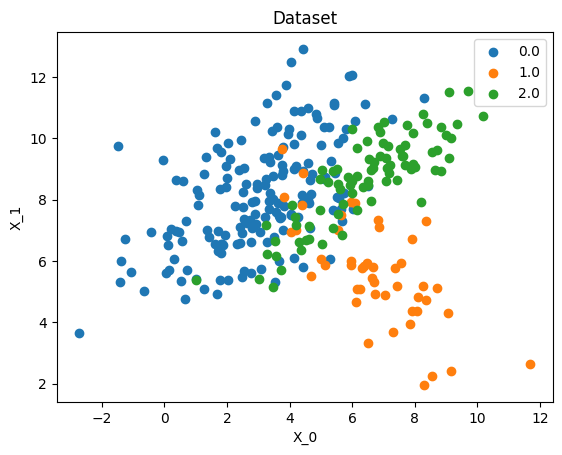

In [29]:
classes_groups = train_set.groupby('y_0')
fig, ax = plt.subplots()
for i, (label, group) in enumerate(classes_groups):
    ax.scatter(group['X_0'], group['X_1'],
            label=label)
plt.xlabel('X_0')
plt.ylabel('X_1')
ax.legend()
plt.title("Dataset")
plt.show()

### Classifiers Declaration

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

In [31]:
names = [
    "Logistic Regression",
    "Gaussian Naive Bayes",
    "Quadratic Discriminant Analysis",
    "Decision Tree"
]

classifiers = [
    LogisticRegression(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier()
]

### Compute true probabilities

In [32]:
INITIAL_TRAIN_SIZE = 20
N_SAMPLES = 280

In [33]:
mul_normal_per_class = simulation.concept_mapping['concept_0']
prior_per_class = simulation.prior_probs_per_concept[0]

train, _ = train_test_split(train_set, train_size=INITIAL_TRAIN_SIZE, random_state=0)

p_y_given_x = pd.DataFrame(columns=[list(range(N_CLASSES))])



for index, row in test_set.iterrows():

    p_x_given_y = [mul_normal_per_class["class_" + str(class_)] for class_ in list(range(N_CLASSES))]

    denominator = sum(mul_normal.pdf(row[:-1]) * prior_per_class[class_] for class_, mul_normal in enumerate(mul_normal_per_class.values()))

    p_y_given_x.loc[index] = (np.array([p_x_given_y[class_].pdf(row[:-1].to_numpy()) * prior_per_class[class_] for class_ in list(range(N_CLASSES))])) / denominator


In [34]:
p_y_given_x.sum(axis=1)

300    1.0
301    1.0
302    1.0
303    1.0
304    1.0
      ... 
395    1.0
396    1.0
397    1.0
398    1.0
399    1.0
Length: 100, dtype: float64

In [35]:
training_sizes = list(range(INITIAL_TRAIN_SIZE, INITIAL_TRAIN_SIZE + N_SAMPLES))

accuracy_per_classifier = {}
proba_per_classifier = {}

for name in names:
    accuracy_per_classifier[name] = []
    proba_per_classifier[name] = []

n_samples = INITIAL_TRAIN_SIZE

for i in range(N_SAMPLES):

    train, _ = train_test_split(train_set, train_size=n_samples, random_state=0)

    for name, clf in zip(names, classifiers):
        clf.fit(train[["X_0", "X_1"]], train["y_0"])

        accuracy = clf.score(test_set[["X_0", "X_1"]], test_set["y_0"])
        accuracy_per_classifier[name].append(accuracy)

        proba = clf.predict_proba(test_set[["X_0", "X_1"]])
        proba_per_classifier[name].append(pd.DataFrame(proba))

    n_samples += 1

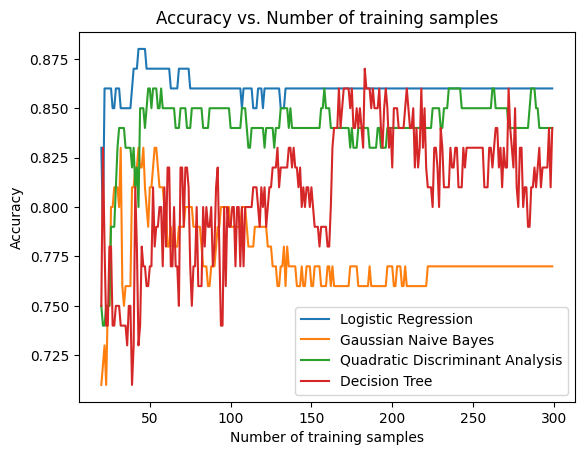

In [36]:
for name in names:
    plt.plot(training_sizes, accuracy_per_classifier[name], label=name)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of training samples')
plt.legend()
plt.show()

### Compute MAE

In [37]:
from sklearn.metrics import mean_absolute_error

In [38]:
mae_per_classifier = {}
for name in names:
    mae_per_classifier[name] = []

    for proba in proba_per_classifier[name]:

        mae = mean_absolute_error(p_y_given_x, proba)
        mae_per_classifier[name].append(mae)

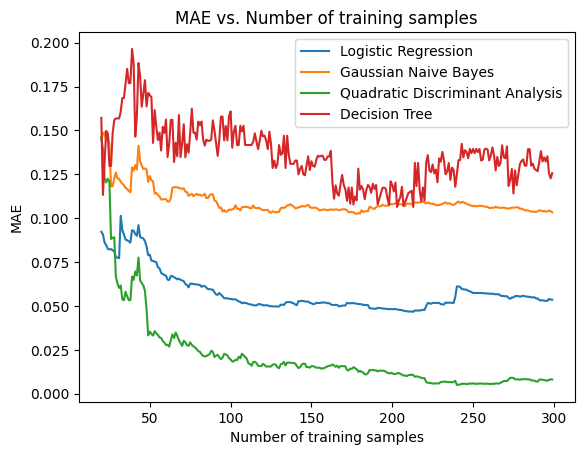

In [39]:
for name in names:
    plt.plot(training_sizes, mae_per_classifier[name], label=name)
plt.xlabel('Number of training samples')
plt.ylabel('MAE')
plt.title('MAE vs. Number of training samples')
plt.legend()
plt.show()